# Elo Merchant Category Recommendation

## Introduction

Elo, one of the largest payment brands in Brazil, has built partnerships with merchants in order to offer promotions or discounts to cardholders. The objective of the competition is to identify and serve the most relevant opportunities to individuals, by uncovering signal in customer loyalty.

### Problem Syntesis

Based on historical transactions, Elo has picked new merchants that are to be recommended for each cardholder. Since then, for each card Elo gathered transaction history for all the new merchants that have appeared on the card. By analyzing each card's new merchant activity their loyalty score was calculated. In this project, our goal is to evaluate Elo's recommendation algorithm by trying to predict in which cases it's going to work well (yielding a high loyalty score) and in which cases - not (yielding a low loyalty score).

### Load Packages

In [1]:
import datetime
import gc
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import warnings
from contextlib import contextmanager
from pandas.core.common import SettingWithCopyWarning
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
import pandas_profiling
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\newton\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas_profiling\plot.py:15: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use(BACKEND)


## Exploratory Data Analysis

First, as we are provided with the data dictionary lets import that!

In [2]:
data_dictionary_train=pd.read_excel('Data_Dictionary.xlsx',sheet_name='train')
data_dictionary_history=pd.read_excel('Data_Dictionary.xlsx',sheet_name='history')
data_dictionary_new_merchant_period=pd.read_excel('Data_Dictionary.xlsx',sheet_name='new_merchant_period')
data_dictionary_merchant=pd.read_excel('Data_Dictionary.xlsx',sheet_name='merchant')


Lets then import the train and test data.

In [3]:
train_df = pd.read_csv('train.csv', index_col=['card_id'], parse_dates=["first_active_month"], nrows = None)
test_df = pd.read_csv('test.csv', index_col=['card_id'], parse_dates=["first_active_month"])
print("Number of rows and columns in train set : ",train_df.shape)
print("Number of rows and columns in test set : ",test_df.shape)

Number of rows and columns in train set :  (201917, 5)
Number of rows and columns in test set :  (123623, 4)


In [4]:
train_df.head()

,first_active_month,feature_1,feature_2,feature_3,target
card_id,,,,,
C_ID_92a2005557,2017-06-01,5,2,1,-0.820283
C_ID_3d0044924f,2017-01-01,4,1,0,0.392913
C_ID_d639edf6cd,2016-08-01,2,2,0,0.688056
C_ID_186d6a6901,2017-09-01,4,3,0,0.142495
C_ID_cdbd2c0db2,2017-11-01,1,3,0,-0.159749


In [5]:
data_dictionary_train[1:8]

,train.csv,Unnamed: 1
1,Columns,Description
2,card_id,Unique card identifier
3,first_active_month,"'YYYY-MM', month of first purchase"
4,feature_1,Anonymized card categorical feature
5,feature_2,Anonymized card categorical feature
6,feature_3,Anonymized card categorical feature
7,target,Loyalty numerical score calculated 2 months af...


Now lets look at overall exploratory statistics using pandas profiling. I have found it to be a extremely useful tool to quickly explore different pandas datasets.

From their GitHub page - For each column the following statistics - if relevant for the column type - are presented in an interactive HTML report:

* **Essentials**: type, unique values, missing values
* **Quantile statistics** like minimum value, Q1, median, Q3, maximum, range, interquartile range
* **Descriptive statistics** like mean, mode, standard deviation, sum, median absolute deviation, coefficient of variation, kurtosis, skewness
* **Most frequent values**
* **Histogram**
* **Correlations** highlighting of highly correlated variables, Spearman and Pearson matrixes

To learn more: https://github.com/pandas-profiling/pandas-profiling

In [6]:
pandas_profiling.ProfileReport(train_df)

Number of variables,6
Number of observations,201917
Total Missing (%),0.0%
Total size in memory,9.2 MiB
Average record size in memory,48.0 B
Numeric,3
Categorical,0
Boolean,1
Date,1
Text (Unique),1
Rejected,0


Let us now do some of our own custom exploratory analysis. Lets first analyze the target variable!

In [7]:
train_df['target'].describe()

count    201917.000000
mean         -0.393636
std           3.850500
min         -33.219281
25%          -0.883110
50%          -0.023437
75%           0.765453
max          17.965068
Name: target, dtype: float64

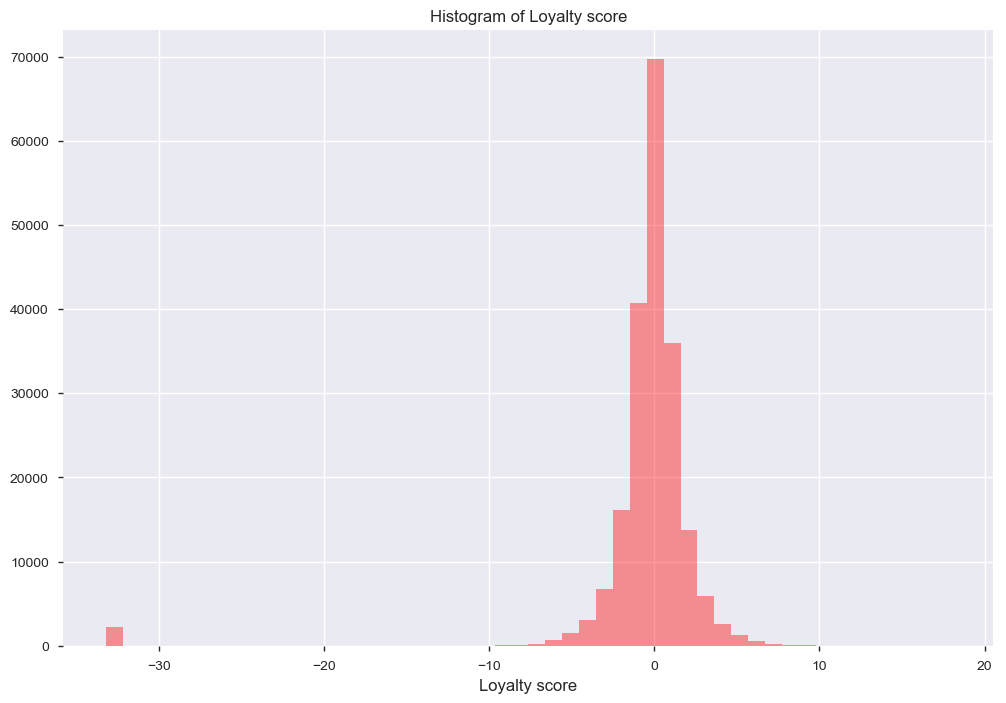

In [8]:
plt.figure(figsize=(12,8))
sns.distplot(train_df['target'].values, bins=50, kde=False, color="red")
plt.title("Histogram of Loyalty score")
plt.xlabel('Loyalty score', fontsize=12)
plt.show()

We can see that some of the loyalty values are far apart (less than -30) compared to others. Let us just get their count.

In [9]:
(train_df['target']<-30).sum()

2207

There are 2207 rows (almost 1% of the data), which has values different from the rest. Since the metric is RMSE these rows might play an important role.

Let us see the distribution of the feature variables between train and test.

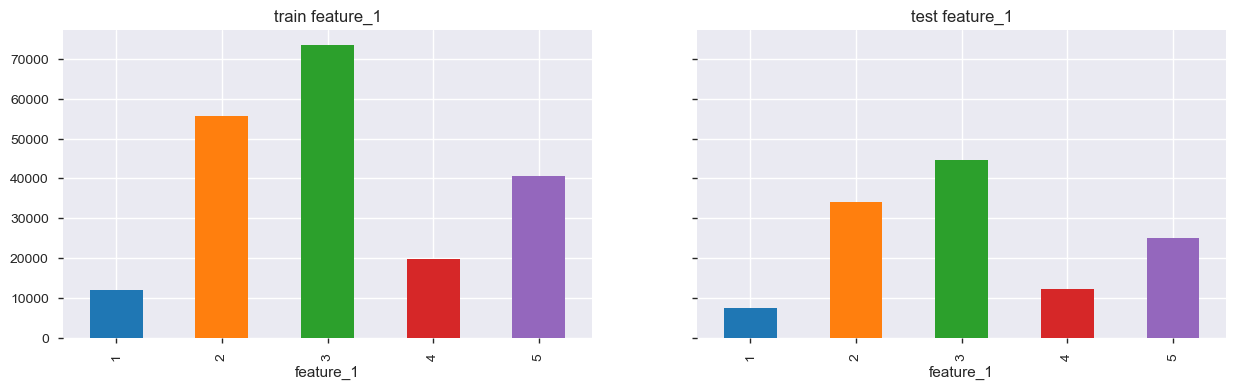

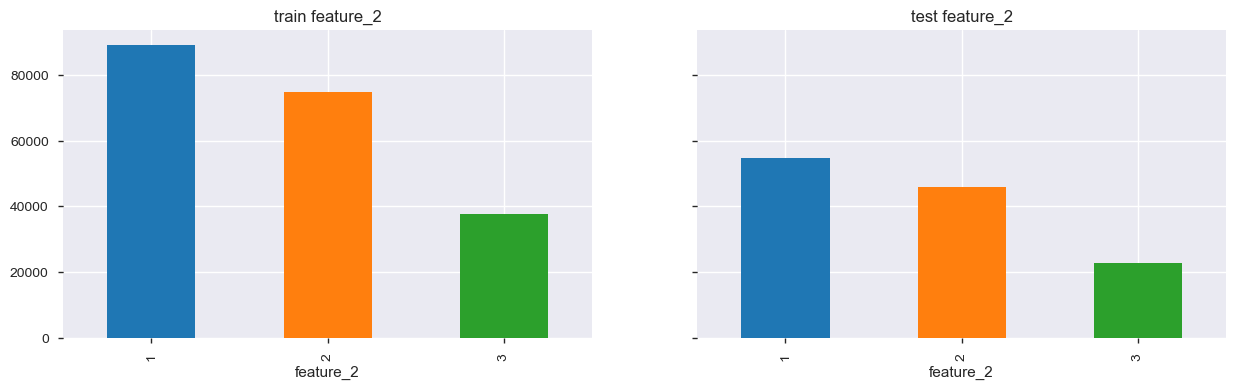

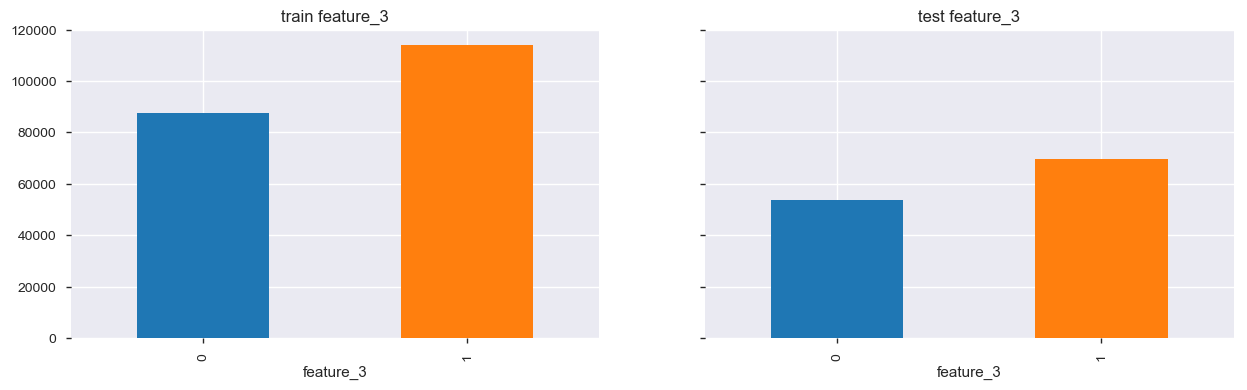

In [10]:
features = ['feature_1', 'feature_2', 'feature_3']
for feature in features:
    fig, axes = plt.subplots(nrows=1, ncols=2,sharey='row', )
    train_df.groupby(feature).count()['first_active_month'].plot(kind='bar',
                                                              title='train {}'.format(feature),
                                                              figsize=(15, 4),
                                                              ax=axes[0])
    test_df.groupby(feature).count()['first_active_month'].plot(kind='bar',
                                                              title='test {}'.format(feature),
                                                              figsize=(15, 4)
                                                               )
    plt.show()

From the above graphs the distributions of the three features between train and test look the same. Lets see if we can look at the data from another angle.

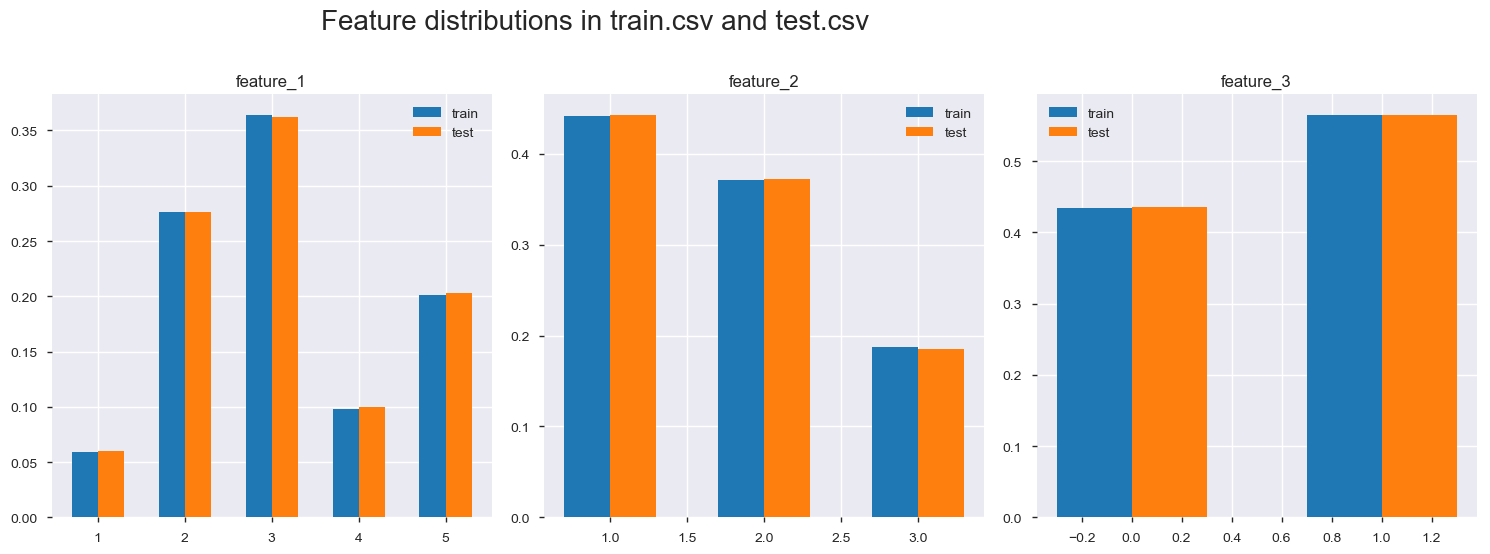

In [11]:
plt.figure(figsize=[15,5])
plt.suptitle('Feature distributions in train.csv and test.csv', fontsize=20, y=1.1, x=.4)
for num, col in enumerate(['feature_1', 'feature_2', 'feature_3']):
    plt.subplot(1, 3, num+1)
    v_c = train_df[col].value_counts() / train_df.shape[0]
    plt.bar(v_c.index, v_c, label=('train'), align='edge', width=-0.3)
    v_c = test_df[col].value_counts() / test_df.shape[0]
    plt.bar(v_c.index, v_c, label=('test'), align='edge', width=0.3)
    plt.title(col)
    plt.legend()
plt.tight_layout()
plt.show()

The distribution seems the same between test and control for the three features


Let us see the distribution of the feature variables vs the target variable

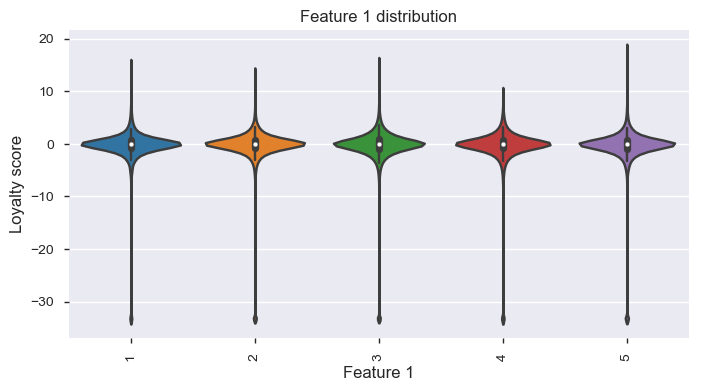

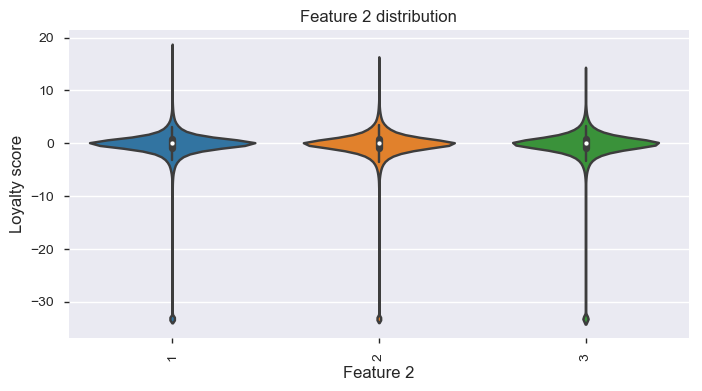

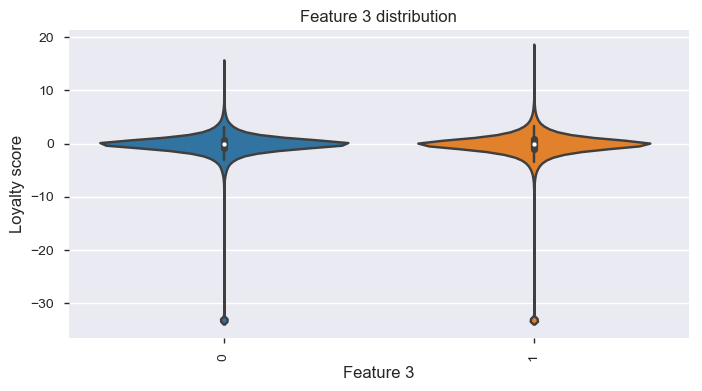

In [12]:
# Feature 1
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_1", y='target', data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 1 distribution")
plt.show()

# Feature 2
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_2", y='target', data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 2', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 2 distribution")
plt.show()

# Feature 3
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_3", y='target', data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 3', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 3 distribution")
plt.show()

The distribution of the different categories in all three features look kind of similar.  Also it is worth noticing that mean target values of each catogory of these features is near zero.

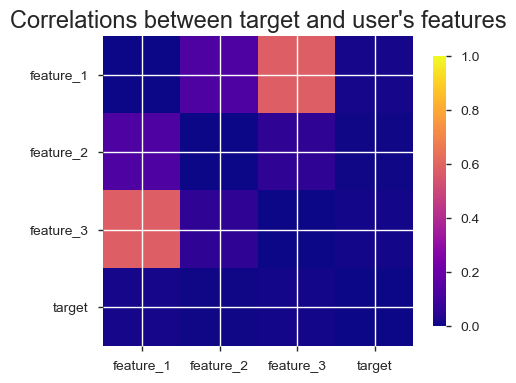

In [13]:
# Correlation plots
corrs = np.abs(train_df.corr())
np.fill_diagonal(corrs.values, 0)
plt.figure(figsize=[5,5])
plt.imshow(corrs, cmap='plasma', vmin=0, vmax=1)
plt.colorbar(shrink=0.7)
plt.xticks(range(corrs.shape[0]), list(corrs.columns))
plt.yticks(range(corrs.shape[0]), list(corrs.columns))
plt.title('Correlations between target and user\'s features', fontsize=17)
plt.show()

Target doest seem to be correlated to any of the three features.

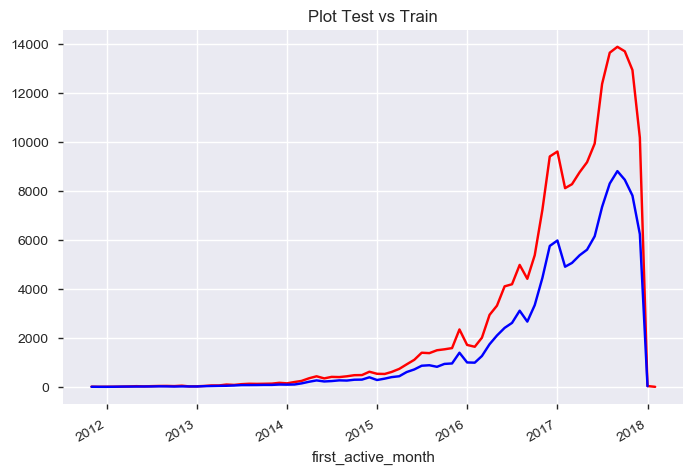

In [14]:
ax = train_df.groupby('first_active_month').size().plot( color='r')
test_df.groupby('first_active_month').size().plot( color='b', ax=ax)
plt.title("Plot Test vs Train")
plt.show()

The distribution looks the same for test and control. With the majority of the data coming from 2017.

**Historical Transactions**

Now let us look at the historical transactions data for the cards.

In [15]:
hist_df = pd.read_csv("historical_transactions.csv")
print("Number of rows and columns in historical transactions : ",hist_df.shape)

Number of rows and columns in historical transactions :  (29112361, 14)


In [16]:
hist_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [17]:
data_dictionary_history[1:]

,historical_transactions.csv,Unnamed: 1
1,Columns,Description
2,card_id,Card identifier
3,month_lag,month lag to reference date
4,purchase_date,Purchase date
5,authorized_flag,"Y' if approved, 'N' if denied"
6,category_3,anonymized category
7,installments,number of installments of purchase
8,category_1,anonymized category
9,merchant_category_id,Merchant category identifier (anonymized )
10,subsector_id,Merchant category group identifier (anonymized )


In [18]:
pandas_profiling.ProfileReport(hist_df)

Number of variables,14
Number of observations,29112361
Total Missing (%),0.7%
Total size in memory,3.0 GiB
Average record size in memory,112.0 B
Numeric,8
Categorical,6
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [19]:
merchants_df=pd.read_csv('merchants.csv')
print("Number of rows and columns in main merchants : ",merchants_df.shape)

Number of rows and columns in main merchants :  (334696, 22)


In [20]:
merchants_df.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [21]:
data_dictionary_merchant[1:]

,merchants.csv,Unnamed: 1
1,Columns,Description
2,merchant_id,Unique merchant identifier
3,merchant_group_id,Merchant group (anonymized )
4,merchant_category_id,Unique identifier for merchant category (anony...
5,subsector_id,Merchant category group (anonymized )
6,numerical_1,anonymized measure
7,numerical_2,anonymized measure
8,category_1,anonymized category
9,most_recent_sales_range,Range of revenue (monetary units) in last acti...
10,most_recent_purchases_range,Range of quantity of transactions in last acti...


In [22]:
pandas_profiling.ProfileReport(merchants_df)

Number of variables,22
Number of observations,334696
Total Missing (%),0.2%
Total size in memory,56.2 MiB
Average record size in memory,176.0 B
Numeric,13
Categorical,5
Boolean,0
Date,0
Text (Unique),0
Rejected,4


In [23]:
new_merchant_df=pd.read_csv('new_merchant_transactions.csv')
print("Number of rows and columns in new merchant transactions : ",new_merchant_df.shape)

Number of rows and columns in new merchant transactions :  (1963031, 14)


In [24]:
new_merchant_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [25]:
data_dictionary_new_merchant_period[1:]

,new_merchant_period.csv,Unnamed: 1
1,Columns,Description
2,card_id,Card identifier
3,month_lag,month lag to reference date
4,purchase_date,Purchase date
5,authorized_flag,"Y' if approved, 'N' if denied"
6,category_3,anonymized category
7,installments,number of installments of purchase
8,category_1,anonymized category
9,merchant_category_id,Merchant category identifier (anonymized )
10,subsector_id,Merchant category group identifier (anonymized )


In [26]:
pandas_profiling.ProfileReport(new_merchant_df)

Number of variables,14
Number of observations,1963031
Total Missing (%),0.7%
Total size in memory,209.7 MiB
Average record size in memory,112.0 B
Numeric,7
Categorical,5
Boolean,1
Date,0
Text (Unique),0
Rejected,1


## Model Iterations

To reduce memory usage

https://www.kaggle.com/frankherfert/tips-tricks-for-working-with-large-datasets

In [27]:

# Reduce memory function - very useful!

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df
    

In [28]:

# rmse calculation - as per competiiton guidelines
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns] 
    return df, new_columns
    
# Display feature importance 
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')


In [29]:
# Preprocessing train & test
def train_test(num_rows=None):

    # load csv
    train_df = pd.read_csv('train.csv', index_col=['card_id'], nrows=num_rows)
    test_df = pd.read_csv('test.csv', index_col=['card_id'], nrows=num_rows)

    print("Train samples: {}, test samples: {}".format(len(train_df), len(test_df)))

    # Outlier flag 
    train_df['outliers'] = 0
    train_df.loc[train_df['target'] < -30, 'outliers'] = 1

    # Set target as nan
    test_df['target'] = np.nan

    # Merge to create derived columns in one shot
    df = train_df.append(test_df)

    del train_df, test_df
    gc.collect()

    # Datetime
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])

    # Datetime features
    df['quarter'] = df['first_active_month'].dt.quarter
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days

    df['days_feature1'] = df['elapsed_time'] * df['feature_1']
    df['days_feature2'] = df['elapsed_time'] * df['feature_2']
    df['days_feature3'] = df['elapsed_time'] * df['feature_3']

    df['days_feature1_ratio'] = df['feature_1'] / df['elapsed_time']
    df['days_feature2_ratio'] = df['feature_2'] / df['elapsed_time']
    df['days_feature3_ratio'] = df['feature_3'] / df['elapsed_time']

    # One hot encoding
    df, cols = one_hot_encoder(df, nan_as_category=False)

    for f in ['feature_1','feature_2','feature_3']:
        order_label = df.groupby([f])['outliers'].mean()
        df[f+'mean'] = df[f].map(order_label)

    df['feature_sum'] = df['feature_1'] + df['feature_2'] + df['feature_3']
    df['feature_mean'] = df['feature_sum']/3
    df['feature_max'] = df[['feature_1', 'feature_2', 'feature_3']].max(axis=1)
    df['feature_min'] = df[['feature_1', 'feature_2', 'feature_3']].min(axis=1)
    df['feature_var'] = df[['feature_1', 'feature_2', 'feature_3']].std(axis=1)

    return df


In [30]:

# Preprocessing historical transactions
def historical_transactions(num_rows=None):
    # load csv
    hist_df = pd.read_csv('historical_transactions.csv', nrows=num_rows)

    # fillna - based on guidelines from ELo
    hist_df['category_2'].fillna(1.0,inplace=True)
    hist_df['category_3'].fillna('A',inplace=True)
    hist_df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
    hist_df['installments'].replace(-1, np.nan,inplace=True) 
    hist_df['installments'].replace(999, np.nan,inplace=True)

    # Trim
    hist_df['purchase_amount'] = hist_df['purchase_amount'].apply(lambda x: min(x, 0.8))

    # Y/N to 1/0
    hist_df['authorized_flag'] = hist_df['authorized_flag'].map({'Y': 1, 'N': 0}).astype(int)
    hist_df['category_1'] = hist_df['category_1'].map({'Y': 1, 'N': 0}).astype(int)
    hist_df['category_3'] = hist_df['category_3'].map({'A':0, 'B':1, 'C':2})

    # datetime features
    hist_df['purchase_date'] = pd.to_datetime(hist_df['purchase_date'])
    hist_df['month'] = hist_df['purchase_date'].dt.month
    hist_df['day'] = hist_df['purchase_date'].dt.day
    hist_df['hour'] = hist_df['purchase_date'].dt.hour
    hist_df['weekofyear'] = hist_df['purchase_date'].dt.weekofyear
    hist_df['weekday'] = hist_df['purchase_date'].dt.weekday
    hist_df['weekend'] = (hist_df['purchase_date'].dt.weekday >=5).astype(int)

    # Additional features
    hist_df['price'] = hist_df['purchase_amount'] / hist_df['installments']

    # Based on EDA important holidays showed strong correlation 
    
    #Christmas : December 25 2017
    hist_df['Christmas_Day_2017']=(pd.to_datetime('2017-12-25')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Mothers Day: May 14 2017
    hist_df['Mothers_Day_2017']=(pd.to_datetime('2017-06-04')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #fathers day: August 13 2017
    hist_df['fathers_day_2017']=(pd.to_datetime('2017-08-13')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Childrens day: October 12 2017
    hist_df['Children_day_2017']=(pd.to_datetime('2017-10-12')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Valentine's Day : 12th June, 2017
    hist_df['Valentine_Day_2017']=(pd.to_datetime('2017-06-12')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Black Friday : 24th November 2017
    hist_df['Black_Friday_2017']=(pd.to_datetime('2017-11-24') - hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

    #2018
    #Mothers Day: May 13 2018
    hist_df['Mothers_Day_2018']=(pd.to_datetime('2018-05-13')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

    hist_df['month_diff'] = ((datetime.datetime.today() - hist_df['purchase_date']).dt.days)//30
    hist_df['month_diff'] += hist_df['month_lag']

    # Additional features
    hist_df['duration'] = hist_df['purchase_amount']*hist_df['month_diff']
    hist_df['amount_month_ratio'] = hist_df['purchase_amount']/hist_df['month_diff']

    # Reduce memory usage
    hist_df = reduce_mem_usage(hist_df)

    # Now we will aggregate this data to our unit of analysis which is Card_id. 
    
    col_unique =['subsector_id', 'merchant_id', 'merchant_category_id']
    col_seas = ['month', 'hour', 'weekofyear', 'weekday', 'day']

    aggs = {}
    for col in col_unique:
        aggs[col] = ['nunique']

    for col in col_seas:
        aggs[col] = ['nunique', 'mean', 'min', 'max']

    aggs['purchase_amount'] = ['sum','max','min','mean','var','skew']
    aggs['installments'] = ['sum','max','mean','var','skew']
    aggs['purchase_date'] = ['max','min']
    aggs['month_lag'] = ['max','min','mean','var','skew']
    aggs['month_diff'] = ['max','min','mean','var','skew']
    aggs['authorized_flag'] = ['mean']
    aggs['weekend'] = ['mean'] 
    aggs['weekday'] = ['mean'] 
    aggs['day'] = ['nunique', 'mean', 'min'] 
    aggs['category_1'] = ['mean']
    aggs['category_2'] = ['mean']
    aggs['category_3'] = ['mean']
    aggs['card_id'] = ['size','count']
    aggs['price'] = ['sum','mean','max','min','var']
    aggs['Christmas_Day_2017'] = ['mean']
    aggs['Mothers_Day_2017'] = ['mean']
    aggs['fathers_day_2017'] = ['mean']
    aggs['Children_day_2017'] = ['mean']
    aggs['Valentine_Day_2017'] = ['mean']
    aggs['Black_Friday_2017'] = ['mean']
    aggs['Mothers_Day_2018'] = ['mean']
    aggs['duration']=['mean','min','max','var','skew']
    aggs['amount_month_ratio']=['mean','min','max','var','skew']

    for col in ['category_2','category_3']:
        hist_df[col+'_mean'] = hist_df.groupby([col])['purchase_amount'].transform('mean')
        hist_df[col+'_min'] = hist_df.groupby([col])['purchase_amount'].transform('min')
        hist_df[col+'_max'] = hist_df.groupby([col])['purchase_amount'].transform('max')
        hist_df[col+'_sum'] = hist_df.groupby([col])['purchase_amount'].transform('sum')
        aggs[col+'_mean'] = ['mean']

    hist_df = hist_df.reset_index().groupby('card_id').agg(aggs)

    # Change column names 
    hist_df.columns = pd.Index([e[0] + "_" + e[1] for e in hist_df.columns.tolist()])
    hist_df.columns = ['hist_'+ c for c in hist_df.columns]

    hist_df['hist_purchase_date_diff'] = (hist_df['hist_purchase_date_max']-hist_df['hist_purchase_date_min']).dt.days
    hist_df['hist_purchase_date_average'] = hist_df['hist_purchase_date_diff']/hist_df['hist_card_id_size']
    hist_df['hist_purchase_date_uptonow'] = (datetime.datetime.today()-hist_df['hist_purchase_date_max']).dt.days
    hist_df['hist_purchase_date_uptomin'] = (datetime.datetime.today()-hist_df['hist_purchase_date_min']).dt.days

    # Reduce memory usage
    hist_df = reduce_mem_usage(hist_df)

    return hist_df


In [31]:
# Preprocessing new_merchant_transactions similar to historical transactions

def new_merchant_transactions(num_rows=None):

    # load csv
    new_merchant_df = pd.read_csv('new_merchant_transactions.csv', nrows=num_rows)

    # Fillna
    new_merchant_df['category_2'].fillna(1.0,inplace=True)
    new_merchant_df['category_3'].fillna('A',inplace=True)
    new_merchant_df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
    new_merchant_df['installments'].replace(-1, np.nan,inplace=True)
    new_merchant_df['installments'].replace(999, np.nan,inplace=True)

    # Trim
    new_merchant_df['purchase_amount'] = new_merchant_df['purchase_amount'].apply(lambda x: min(x, 0.8))

    # Y/N to 1/0
    new_merchant_df['authorized_flag'] = new_merchant_df['authorized_flag'].map({'Y': 1, 'N': 0}).astype(int)
    new_merchant_df['category_1'] = new_merchant_df['category_1'].map({'Y': 1, 'N': 0}).astype(int)
    new_merchant_df['category_3'] = new_merchant_df['category_3'].map({'A':0, 'B':1, 'C':2}).astype(int)

    # Datetime features
    new_merchant_df['purchase_date'] = pd.to_datetime(new_merchant_df['purchase_date'])
    new_merchant_df['month'] = new_merchant_df['purchase_date'].dt.month
    new_merchant_df['day'] = new_merchant_df['purchase_date'].dt.day
    new_merchant_df['hour'] = new_merchant_df['purchase_date'].dt.hour
    new_merchant_df['weekofyear'] = new_merchant_df['purchase_date'].dt.weekofyear
    new_merchant_df['weekday'] = new_merchant_df['purchase_date'].dt.weekday
    new_merchant_df['weekend'] = (new_merchant_df['purchase_date'].dt.weekday >=5).astype(int)

    # Additional features
    new_merchant_df['price'] = new_merchant_df['purchase_amount'] / new_merchant_df['installments']

    #Christmas : December 25 2017
    new_merchant_df['Christmas_Day_2017']=(pd.to_datetime('2017-12-25')-new_merchant_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Childrens day: October 12 2017
    new_merchant_df['Children_day_2017']=(pd.to_datetime('2017-10-12')-new_merchant_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Black Friday : 24th November 2017
    new_merchant_df['Black_Friday_2017']=(pd.to_datetime('2017-11-24') - new_merchant_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

    #Mothers Day: May 13 2018
    new_merchant_df['Mothers_Day_2018']=(pd.to_datetime('2018-05-13')-new_merchant_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

    new_merchant_df['month_diff'] = ((datetime.datetime.today() - new_merchant_df['purchase_date']).dt.days)//30
    new_merchant_df['month_diff'] += new_merchant_df['month_lag']

    # Additional features
    new_merchant_df['duration'] = new_merchant_df['purchase_amount']*new_merchant_df['month_diff']
    new_merchant_df['amount_month_ratio'] = new_merchant_df['purchase_amount']/new_merchant_df['month_diff']

    # Reduce memory usage
    new_merchant_df = reduce_mem_usage(new_merchant_df)

    col_unique =['subsector_id', 'merchant_id', 'merchant_category_id']
    col_seas = ['month', 'hour', 'weekofyear', 'weekday', 'day']

    aggs = {}
    for col in col_unique:
        aggs[col] = ['nunique']

    for col in col_seas:
        aggs[col] = ['nunique', 'mean', 'min', 'max']

    aggs['purchase_amount'] = ['sum','max','min','mean','var','skew']
    aggs['installments'] = ['sum','max','mean','var','skew']
    aggs['purchase_date'] = ['max','min']
    aggs['month_lag'] = ['max','min','mean','var','skew']
    aggs['month_diff'] = ['mean','var','skew']
    aggs['weekend'] = ['mean']
    aggs['month'] = ['mean', 'min', 'max']
    aggs['weekday'] = ['mean', 'min', 'max']
    aggs['category_1'] = ['mean']
    aggs['category_2'] = ['mean']
    aggs['category_3'] = ['mean']
    aggs['card_id'] = ['size','count']
    aggs['price'] = ['mean','max','min','var']
    aggs['Christmas_Day_2017'] = ['mean']
    aggs['Children_day_2017'] = ['mean']
    aggs['Black_Friday_2017'] = ['mean']
    aggs['Mothers_Day_2018'] = ['mean']
    aggs['duration']=['mean','min','max','var','skew']
    aggs['amount_month_ratio']=['mean','min','max','var','skew']

    for col in ['category_2','category_3']:
        new_merchant_df[col+'_mean'] = new_merchant_df.groupby([col])['purchase_amount'].transform('mean')
        new_merchant_df[col+'_min'] = new_merchant_df.groupby([col])['purchase_amount'].transform('min')
        new_merchant_df[col+'_max'] = new_merchant_df.groupby([col])['purchase_amount'].transform('max')
        new_merchant_df[col+'_sum'] = new_merchant_df.groupby([col])['purchase_amount'].transform('sum')
        aggs[col+'_mean'] = ['mean']

    new_merchant_df = new_merchant_df.reset_index().groupby('card_id').agg(aggs)

    # Change column name
    new_merchant_df.columns = pd.Index([e[0] + "_" + e[1] for e in new_merchant_df.columns.tolist()])
    new_merchant_df.columns = ['new_'+ c for c in new_merchant_df.columns]

    new_merchant_df['new_purchase_date_diff'] = (new_merchant_df['new_purchase_date_max']-new_merchant_df['new_purchase_date_min']).dt.days
    new_merchant_df['new_purchase_date_average'] = new_merchant_df['new_purchase_date_diff']/new_merchant_df['new_card_id_size']
    new_merchant_df['new_purchase_date_uptonow'] = (datetime.datetime.today()-new_merchant_df['new_purchase_date_max']).dt.days
    new_merchant_df['new_purchase_date_uptomin'] = (datetime.datetime.today()-new_merchant_df['new_purchase_date_min']).dt.days

    # Reduce memory usage
    new_merchant_df = reduce_mem_usage(new_merchant_df)

    return new_merchant_df


In [32]:
# additional features
def additional_features(df):
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['hist_last_buy'] = (df['hist_purchase_date_max'] - df['first_active_month']).dt.days
    df['new_first_buy'] = (df['new_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_last_buy'] = (df['new_purchase_date_max'] - df['first_active_month']).dt.days

    date_features=['hist_purchase_date_max','hist_purchase_date_min',
                   'new_purchase_date_max', 'new_purchase_date_min']

    for f in date_features:
        df[f] = df[f].astype(np.int64) * 1e-9

    df['card_id_total'] = df['new_card_id_size']+df['hist_card_id_size']
    df['card_id_cnt_total'] = df['new_card_id_count']+df['hist_card_id_count']
    df['card_id_cnt_ratio'] = df['new_card_id_count']/df['hist_card_id_count']
    df['purchase_amount_total'] = df['new_purchase_amount_sum']+df['hist_purchase_amount_sum']
    df['purchase_amount_mean'] = df['new_purchase_amount_mean']+df['hist_purchase_amount_mean']
    df['purchase_amount_max'] = df['new_purchase_amount_max']+df['hist_purchase_amount_max']
    df['purchase_amount_min'] = df['new_purchase_amount_min']+df['hist_purchase_amount_min']
    df['purchase_amount_ratio'] = df['new_purchase_amount_sum']/df['hist_purchase_amount_sum']
    df['month_diff_mean'] = df['new_month_diff_mean']+df['hist_month_diff_mean']
    df['month_diff_ratio'] = df['new_month_diff_mean']/df['hist_month_diff_mean']
    df['month_lag_mean'] = df['new_month_lag_mean']+df['hist_month_lag_mean']
    df['month_lag_max'] = df['new_month_lag_max']+df['hist_month_lag_max']
    df['month_lag_min'] = df['new_month_lag_min']+df['hist_month_lag_min']
    df['category_1_mean'] = df['new_category_1_mean']+df['hist_category_1_mean']
    df['installments_total'] = df['new_installments_sum']+df['hist_installments_sum']
    df['installments_mean'] = df['new_installments_mean']+df['hist_installments_mean']
    df['installments_max'] = df['new_installments_max']+df['hist_installments_max']
    df['installments_ratio'] = df['new_installments_sum']/df['hist_installments_sum']
    df['price_total'] = df['purchase_amount_total'] / df['installments_total']
    df['price_mean'] = df['purchase_amount_mean'] / df['installments_mean']
    df['price_max'] = df['purchase_amount_max'] / df['installments_max']
    df['duration_mean'] = df['new_duration_mean']+df['hist_duration_mean']
    df['duration_min'] = df['new_duration_min']+df['hist_duration_min']
    df['duration_max'] = df['new_duration_max']+df['hist_duration_max']
    df['amount_month_ratio_mean']=df['new_amount_month_ratio_mean']+df['hist_amount_month_ratio_mean']
    df['amount_month_ratio_min']=df['new_amount_month_ratio_min']+df['hist_amount_month_ratio_min']
    df['amount_month_ratio_max']=df['new_amount_month_ratio_max']+df['hist_amount_month_ratio_max']
    df['new_CLV'] = df['new_card_id_count'] * df['new_purchase_amount_sum'] / df['new_month_diff_mean']
    df['hist_CLV'] = df['hist_card_id_count'] * df['hist_purchase_amount_sum'] / df['hist_month_diff_mean']
    df['CLV_ratio'] = df['new_CLV'] / df['hist_CLV']

    return df


In [33]:



# LightGBM GBDT
def kfold_lightgbm(train_df, test_df, num_folds):
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

    # Cross validation model
    
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=326)
    
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in FEATS_EXCLUDED]

    # k-fold
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['outliers'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['target'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['target'].iloc[valid_idx]

        # Set data structure
        lgb_train = lgb.Dataset(train_x,
                                label=train_y,
                                free_raw_data=False)
        lgb_test = lgb.Dataset(valid_x,
                               label=valid_y,
                               free_raw_data=False)

        # Params optimized by optuna 
        # Check out a tutorial from their GitHub page: https://github.com/pfnet/optuna/blob/master/examples/lightgbm_simple.py
        
        params ={
                'task': 'train',
                'boosting': 'goss',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.01,
                'subsample': 0.9855232997390695,
                'max_depth': 7,
                'top_rate': 0.9064148448434349,
                'num_leaves': 63,
                'min_child_weight': 41.9612869171337,
                'other_rate': 0.0721768246018207,
                'reg_alpha': 9.677537745007898,
                'colsample_bytree': 0.5665320670155495,
                'min_split_gain': 9.820197773625843,
                'reg_lambda': 8.2532317400459,
                'min_data_in_leaf': 21,
                'verbose': -1,
                'seed':int(2**n_fold),
                'bagging_seed':int(2**n_fold),
                'drop_seed':int(2**n_fold)
                }

        reg = lgb.train(
                        params,
                        lgb_train,
                        valid_sets=[lgb_train, lgb_test],
                        valid_names=['train', 'test'],
                        num_boost_round=10000,
                        early_stopping_rounds= 200,
                        verbose_eval=100
                        )

        oof_preds[valid_idx] = reg.predict(valid_x, num_iteration=reg.best_iteration)
        sub_preds += reg.predict(test_df[feats], num_iteration=reg.best_iteration) / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = np.log1p(reg.feature_importance(importance_type='gain', iteration=reg.best_iteration))
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d RMSE : %.6f' % (n_fold + 1, rmse(valid_y, oof_preds[valid_idx])))
        del reg, train_x, train_y, valid_x, valid_y
        gc.collect()

    # display importances
    display_importances(feature_importance_df)

    
    # save submission file
    test_df.loc[:,'target'] = sub_preds
    test_df = test_df.reset_index()
    test_df[['card_id', 'target']].to_csv('submission.csv', index=False)


In [34]:

num_rows = 1000
df = train_test(num_rows)
df = pd.merge(df, historical_transactions(num_rows), on='card_id', how='outer')
df = pd.merge(df, new_merchant_transactions(num_rows), on='card_id', how='outer')
df = additional_features(df)

train_df = df[df['target'].notnull()]
test_df = df[df['target'].isnull()]
del df
gc.collect()


FEATS_EXCLUDED = ['first_active_month', 'target', 'card_id', 'outliers',
                  'hist_purchase_date_max', 'hist_purchase_date_min', 'hist_card_id_size',
                  'new_purchase_date_max', 'new_purchase_date_min', 'new_card_id_size',
                  'OOF_PRED', 'month_0']



kfold_lightgbm(train_df, test_df, num_folds=11, stratified=False)

Train samples: 1000, test samples: 1000
Memory usage after optimization is: 0.06 MB
Decreased by 72.0%
Memory usage after optimization is: 0.00 MB
Decreased by 57.8%
Memory usage after optimization is: 0.06 MB
Decreased by 69.7%
Memory usage after optimization is: 0.01 MB
Decreased by 57.6%


TypeError: kfold_lightgbm() got an unexpected keyword argument 'stratified'